In [37]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import random

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = processor.tokenizer

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
#show this image
image.show()

In [5]:

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [12]:
probs

tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)

In [6]:
from datasets import load_dataset
imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split = 'train'
)
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [7]:
#Tokenize a prompt
inputs = tokenizer("a photo of a cat", return_tensors="pt", padding=True)
print(inputs)

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [8]:
text_embeddings = model.get_text_features(**inputs)
print(text_embeddings.shape)

torch.Size([1, 512])


In [10]:
image = processor(text = None,
                  images = imagenette[0]['image'],
                    return_tensors = "pt"
                  ).pixel_values

print(image.shape)

torch.Size([1, 3, 224, 224])


/var/folders/c3/wt1h7fz910v7vxy5x88m2h_r0000gn/T/ipykernel_69343/3900636962.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.imshow(image[0].squeeze(0).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0298605].


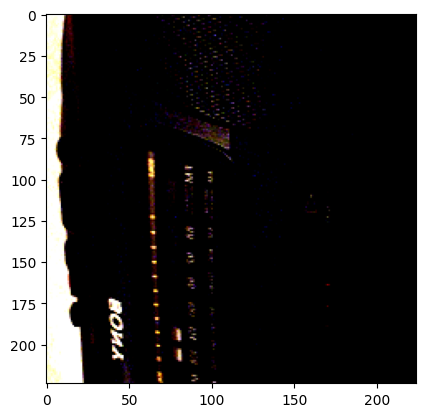

In [11]:
import matplotlib.pyplot as plt
plt.imshow(image[0].squeeze(0).T)

In [12]:
image_embedding = model.get_image_features(pixel_values=image)
image_embedding.shape

torch.Size([1, 512])

In [13]:

# Function to get image embeddings
def get_image_embeddings(image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs

# Function to get text embeddings
def get_text_embeddings(text):
    inputs = processor(text=[text], return_tensors="pt")
    outputs = model.get_text_features(**inputs)
    return outputs

In [14]:
# Ask user for input text
user_input = input("Enter the text to search for: ")

Max_Images_To_Search = 500
# Randomly select 100 images from the dataset
random_indices = random.sample(range(len(imagenette)), Max_Images_To_Search)


# Get text embeddings
text_embeddings = get_text_embeddings(user_input)

# Search all images in a for loop with tqdm loading bar
cosine_similarities = []
for i in tqdm(random_indices, desc="Searching images"):
    image = imagenette[i]['image']
    image_embeddings = get_image_embeddings(image)
    cosine_sim = cosine_similarity(text_embeddings.detach().numpy(), image_embeddings.detach().numpy())
    cosine_similarities.append((i, cosine_sim[0][0]))

# Find the image with the highest cosine similarity
most_similar_image_index = max(cosine_similarities, key=lambda x: x[1])[0]
most_similar_image = imagenette[most_similar_image_index]['image']

# Display the most similar image
most_similar_image.show()

Searching images: 100%|████████████████████████████████| 500/500 [00:37<00:00, 13.31it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
